In [1]:
import argparse
import numpy as np
from softlearning.environments.adapters.gym_adapter import GymAdapter
import gym
import multiworld
multiworld.register_all_envs()
import imageio
import pickle
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import skimage

%matplotlib inline

In [20]:
exp_name = 'test'

In [21]:
cur_dir = os.getcwd()
directory = os.path.join(cur_dir, exp_name)
if not os.path.exists(directory):
    os.makedirs(directory)
directory

'/home/justinvyu/dev/vice/notebooks/bottom_middle'

In [68]:
images = True
NUM_TOTAL_EXAMPLES, ROLLOUT_LENGTH, STEPS_PER_SAMPLE = 1, 15, 1
univ = 'gym'
domain = 'Point2D'
task = 'BoxWall-v1'

# === SET GOAL ===
goal_x, goal_y = (0, 3)
eps = 0.25      # Within 0.25 distance
# ================

init_pos_range = ((goal_x - eps, goal_y - eps), (goal_x + eps, goal_y + eps))
target_pos_range = ((goal_x, goal_y), (goal_x, goal_y))

env_kwargs = {
    'action_scale': 0.5,
    'init_pos_range': init_pos_range,
    'target_pos_range': target_pos_range,
    'render_target': True,
    'images_are_rgb': True,
    'render_onscreen': False,
    'reward_type': 'dense',
    'render_size': 200,
    'observation_keys': ('state_observation', )
}
env = GymAdapter(
    domain=domain,
    task=task,
    **env_kwargs
) 

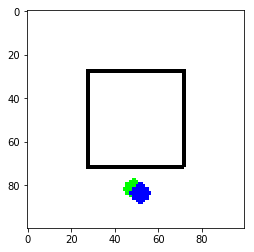

In [50]:
obs = env.reset()
plt.imshow(env.render('rgb_array'))
plt.show()

In [97]:
from copy import deepcopy
from gym.spaces import Box
test = deepcopy(env)
test.init_pos_range = test.target_pos_range

In [100]:
test.init_pos_range.low, test.init_pos_range.high

(array([0., 3.], dtype=float32), array([0., 3.], dtype=float32))

In [99]:
env.init_pos_range.low, env.init_pos_range.high

(array([-0.25,  2.75], dtype=float32), array([0.25, 3.25], dtype=float32))

In [8]:
env.step(env.action_space.sample())

({'state_observation': array([0.31719735, 0.21493012]),
  'state_desired_goal': array([0., 0.])},
 -0.38315677528093733,
 False,
 {'radius': 0.5,
  'target_position': array([0., 0.]),
  'distance_to_target': 0.38315677528093733,
  'velocity': array([0.12861097, 0.12985301], dtype=float32),
  'speed': 0.18276374,
  'is_success': True})

In [91]:
observations = []
actions = []
next_observations = []
num_positives = 0

In [92]:
# reset the environment
while num_positives <= NUM_TOTAL_EXAMPLES:
    prev_obs = env.reset()
    last_action = env.action_space.sample()
    for _ in range(STEPS_PER_SAMPLE):
        obs, rew, done, info = env.step(last_action)
        
    t = 0
    while t < ROLLOUT_LENGTH:
        action = env.action_space.sample()
                
        prev_obs = obs
        # === SPECIFY YOUR GOAL CRITERIA ===
        if info['distance_to_target'] < eps:
            observations.append(prev_obs)
            for _ in range(STEPS_PER_SAMPLE):
                obs, rew, done, info = env.step(action)
            next_observations.append(obs)
            actions.append(action)
            num_positives += 1
        else:
            for _ in range(STEPS_PER_SAMPLE):
                obs, rew, done, info = env.step(action)
        last_action = action
        t += 1

{'state_observation': array([-0.05367414,  3.21116538])} [-0.37334758 -0.33880606] {'state_observation': array([-0.42702172,  2.87235932])}
{'state_observation': array([-0.17881035,  3.12447547])} [-0.36003062  0.32903653] {'state_observation': array([-0.53884097,  3.45351201])}
{'state_observation': array([-0.19675907,  3.14046475])} [-0.11196582 -0.2739679 ] {'state_observation': array([-0.3087249 ,  2.86649686])}
{'state_observation': array([0.15391741, 2.95634728])} [-0.38661417  0.05499957] {'state_observation': array([-0.23269677,  3.01134687])}
{'state_observation': array([-0.23269677,  3.01134687])} [ 0.113878   -0.33147642] {'state_observation': array([-0.11881875,  2.67987045])}
{'state_observation': array([0.08973569, 2.92169138])} [-0.08984046  0.16588745] {'state_observation': array([-1.04778397e-04,  3.08757886e+00])}
{'state_observation': array([-1.04778397e-04,  3.08757886e+00])} [-0.07110044 -0.26788855] {'state_observation': array([-0.07120522,  2.81969031])}
{'state_

In [76]:
goal_obs = {
    key: np.concatenate([
        obs[key][None] for obs in observations
    ], axis=0)
    for key in observations[0].keys()
}
goal_next_obs = {
    key: np.concatenate([
        obs[key][None] for obs in next_observations
    ], axis=0)
    for key in next_observations[0].keys()
}
goal_actions = np.vstack(actions)

goal_transitions = {
    'observations': goal_obs,
    'next_observations': goal_next_obs,
    'actions': goal_actions,
}

In [78]:
goal_obs['state_observation'][0], goal_next_obs['state_observation'][0], goal_actions[0]

(array([-0.17758444,  2.9486336 ]),
 array([-0.26076361,  2.51      ]),
 array([-0.16635834, -0.9481203 ], dtype=float32))

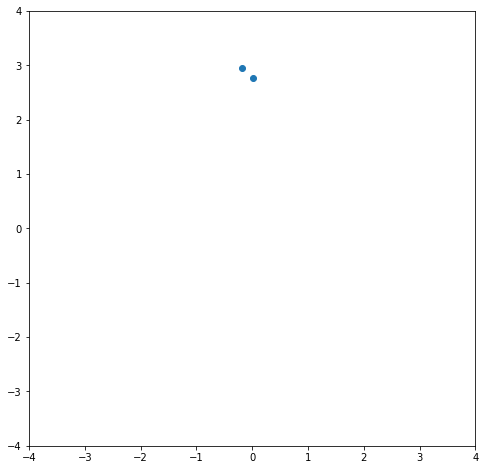

In [81]:
plt.figure(figsize=(8, 8))
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.scatter(goal_transitions['observations']['state_observation'][:, 0], goal_transitions['observations']['state_observation'][:, 1])

In [26]:
goal_examples = {
    key: np.concatenate([
        obs[key][None] for obs in observations
    ], axis=0)
    for key in observations[0].keys()
}
with open(os.path.join(directory, 'positives.pkl'), 'wb') as file:
    pickle.dump(goal_examples, file)